Columns in dataset: ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible']
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
id           0.001531   1.001532  0.003909       -0.006131        0.009193   
treatment   -0.073145   0.929466  0.220093       -0.504519        0.358228   
eligible     0.079235   1.082459  0.268917       -0.447833        0.606303   
age         -0.023681   0.976597  0.111777       -0.242760        0.195399   
x1          -0.015693   0.984429  0.109393       -0.230100        0.198713   
x3           0.042437   1.043350  0.109443       -0.172068        0.256941   
censored     0.281953   1.325716  0.415307       -0.532033        1.095939   
ipcw_weight  0.196738   1.217425  0.921595       -1.609556        2.003031   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate          

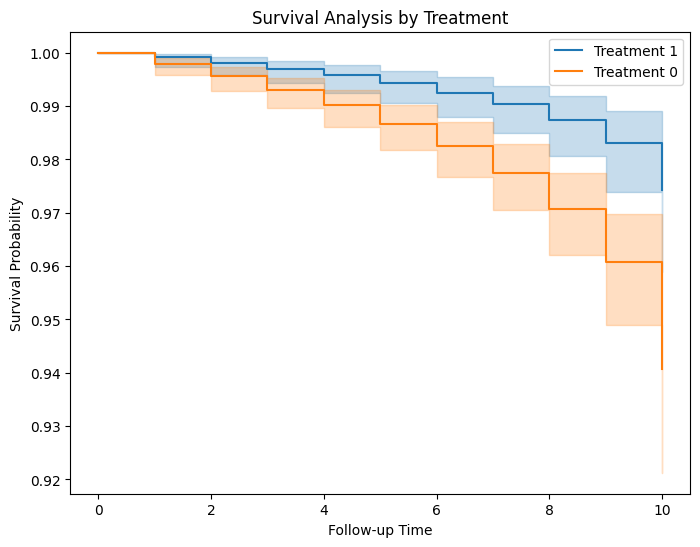

In [25]:
import numpy as np
import pandas as pd
import os
from statsmodels.api import Logit, WLS  # Use WLS instead of OLS
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Create directories to save results
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
trial_itt_dir = os.path.join(os.getcwd(), "trial_itt")

os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

# Load the dataset (Assuming a CSV file)
data_censored = pd.read_csv("data_censored.csv")

# Print column names to verify
print("Columns in dataset:", data_censored.columns.tolist())

# Ensure column names are clean
data_censored.columns = data_censored.columns.str.strip()

# Handle missing values (drop or fill)
data_censored.dropna(inplace=True)

# Standardize numerical columns for stability
scaler = StandardScaler()
data_censored[['age', 'x1', 'x3']] = scaler.fit_transform(data_censored[['age', 'x1', 'x3']])

# Selecting relevant columns
trial_pp = data_censored[['id', 'period', 'treatment', 'outcome', 'eligible', 'age', 'x1', 'x3', 'censored']].copy()
trial_itt = trial_pp.copy()

# Fit a logistic regression model for IPCW
X = trial_pp[['age', 'x1', 'x3']]
y = trial_pp['treatment']

model = LogisticRegression()
model.fit(X, y)

# Compute the probabilities (weights)
trial_pp.loc[:, 'ipcw_weight'] = model.predict_proba(X)[:, 1]

def calculate_weights(data, treatment_col):
    """Computes IPCW using logistic regression and applies winsorization to prevent extreme weights."""
    data = data.copy()

    model = LogisticRegression()
    X = data[['age', 'x1', 'x3']]
    y = data[treatment_col]
    
    model.fit(X, y)
    data.loc[:, 'ipcw_weight'] = model.predict_proba(X)[:, 1]

    # Winsorization: Limit extreme weights to the 99th percentile
    q99 = np.percentile(data['ipcw_weight'], 99)
    data.loc[:, 'ipcw_weight'] = np.minimum(data['ipcw_weight'], q99)

    return data

# Apply weight calculation function
trial_pp = calculate_weights(trial_pp, 'treatment')

# Fit Cox Proportional Hazards Model with censoring adjustment and penalization
cox_model = CoxPHFitter(penalizer=0.1)
cox_model.fit(trial_pp, duration_col='period', event_col='outcome')

print(cox_model.summary)

def expand_trials(data, max_period=10):
    """Expands dataset by duplicating records for multiple periods."""
    expanded_data = pd.concat([data.assign(period=p) for p in range(1, max_period+1)], ignore_index=True)
    return expanded_data

# Expand trials
trial_pp = expand_trials(trial_pp)

# Sample 50% of trial_pp to create trial_itt
trial_itt = trial_pp.sample(frac=0.5, random_state=1234)

def fit_msm(data, weight_col):
    """Fits a weighted regression model."""
    model = WLS(data['outcome'], data[['treatment']], weights=data[weight_col])
    result = model.fit()
    return result

# Fit the Marginal Structural Model
msm_result = fit_msm(trial_itt, 'ipcw_weight')
print(msm_result.summary())

# Visualizing Survival Analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for t in trial_pp['treatment'].unique():
    subset = trial_pp[trial_pp['treatment'] == t]
    kmf.fit(subset['period'], event_observed=subset['outcome'])
    kmf.plot(label=f"Treatment {t}")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Survival Analysis by Treatment")
plt.legend()
plt.show()

